In [1]:
from temporal_walk import TemporalWalk
import matplotlib.pyplot as plt
from test import read_data
from collections import defaultdict

In [2]:
import numpy as np

def generate_temporal_graph_with_increasing_time(n_nodes, total_time):
    x = np.linspace(-3, 3, n_nodes)
    gaussian = np.exp(-x**2)
    
    base_probabilities = gaussian / gaussian.sum()
    
    edges = []
    
    for current_timestamp in range(total_time):
        # Pick nodes based on the probabilities
        node_a = np.random.choice(range(1, n_nodes + 1), p=base_probabilities)
        node_b = np.random.choice(range(1, n_nodes + 1), p=base_probabilities)
        
        # Ensure node_a and node_b are not the same
        while node_a == node_b:
            node_b = np.random.choice(range(1, n_nodes + 1), p=base_probabilities)

        edges.append((node_a, node_b, current_timestamp))
        
    return edges

In [3]:
edges = generate_temporal_graph_with_increasing_time(1000, 100_000)

In [4]:
def plot_node_counts(edges):
    node_counts = defaultdict(int)
    
    for node_a, node_b, _ in edges:
        node_counts[node_a] += 1
        node_counts[node_b] += 1
    
    nodes = list(node_counts.keys())
    counts = list(node_counts.values())
    
    plt.figure(figsize=(10, 6))
    plt.hist(nodes, weights=counts, bins=100, color='red', alpha=0.6)
    
    plt.xlabel('Node')
    plt.ylabel('Number of Temporal Edges')
    plt.title('Node Counts of Temporal Edges')
    
    plt.tight_layout()

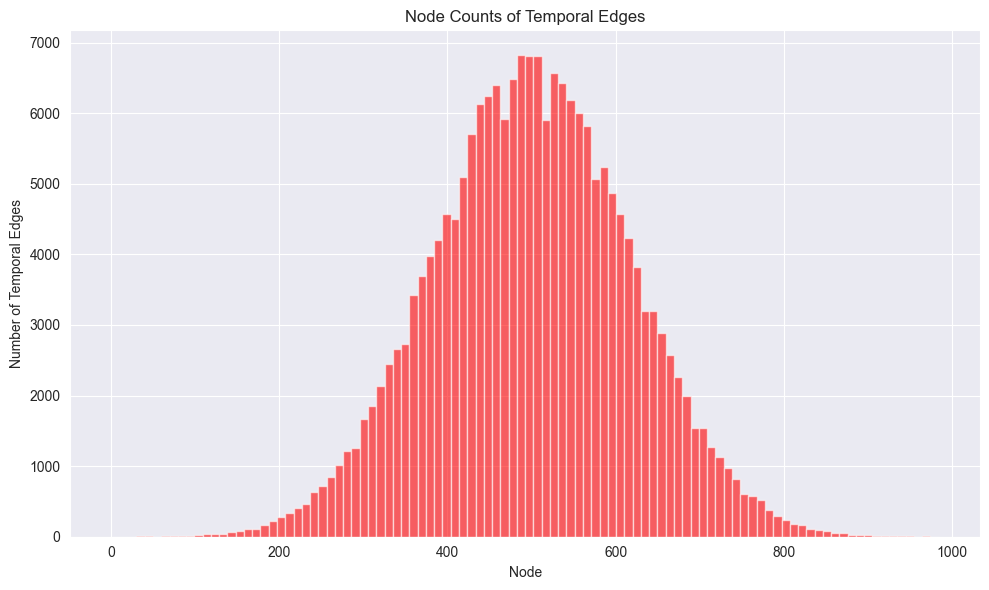

In [5]:
plot_node_counts(edges)
plt.savefig('plots/true_node_counts.png')
plt.show()

In [6]:
NUM_WALKS = 100000
LEN_WALK = 20

In [7]:
def generate_node_vs_interaction_for_pickers(edges):
    picker_types = ["Uniform", "Linear", "Exponential"]
    
    node_results = {}
    node_visit_stats = {}
    
    for picker in picker_types:
        temporal_walk = TemporalWalk(NUM_WALKS, LEN_WALK, picker, None)
        temporal_walk.add_multiple_edges(edges)
        random_walks_with_times = temporal_walk.get_random_walks_with_times("Random")
        walk_lens = [len(walk) for walk in random_walks_with_times]
        
        node_freqs = defaultdict(int)

        for walk in random_walks_with_times:
            for node, time in walk:
                node_freqs[node] += 1
        
        node_results[picker] = node_freqs
        
        node_visit_stats[picker] = {
            "mean": np.mean(list(node_freqs.values())),
            "std_dev": np.std(list(node_freqs.values())),
            "median": np.median(list(node_freqs.values())),
            "mean_walk_lens": np.mean(walk_lens)
        }

    # Create the plot with additional statistical context
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot timestamp distributions with binned data
    for i, picker in enumerate(picker_types):
        nodes = list(node_results[picker].keys())
        counts = list(node_results[picker].values())
        
        axes[i].hist(nodes, weights=counts, bins=100, color='red', alpha=0.6)
        
        axes[i].set_title(f"Node Frequencies ({picker} Picker)")
        axes[i].set_xlabel("Node")
        axes[i].set_ylabel("Frequency")
        
        axes[i].text(
            0.05, 
            0.95, 
            f"Mean: {node_visit_stats[picker]['mean']:.2f}\nMedian: {node_visit_stats[picker]['median']:.2f}\nMean Walk Lens: {node_visit_stats[picker]['mean_walk_lens']:.2f}",
            transform=axes[i].transAxes, 
            fontsize=12, 
            verticalalignment='top'
        )

    plt.tight_layout()
    return fig

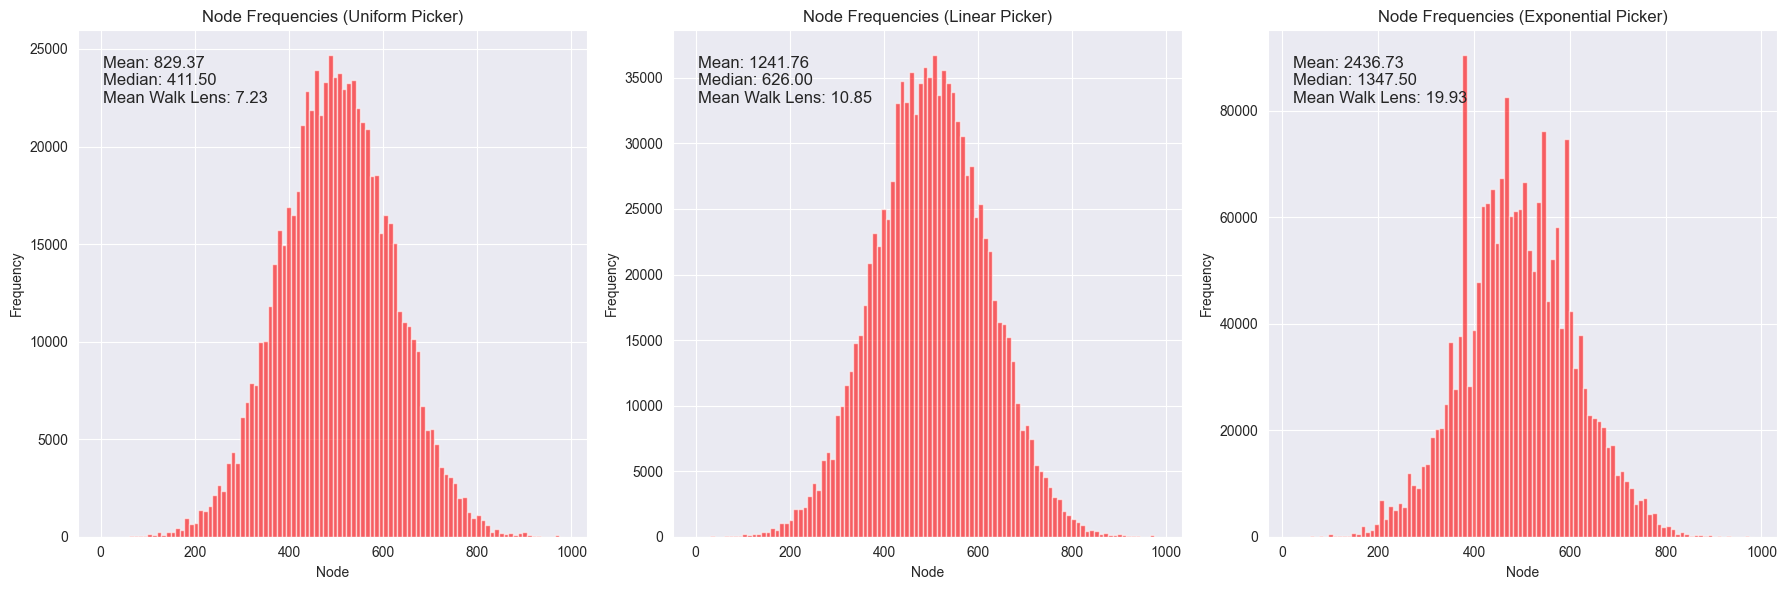

In [8]:
generate_node_vs_interaction_for_pickers(edges)
plt.savefig('plots/walk_node_counts.png')
plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def generate_time_vs_interaction_for_pickers(edges):
    picker_types = ["Uniform", "Linear", "Exponential"]
    MIN_TIMESTAMP = -9223372036854775808
    MAX_TIMESTAMP = 9223372036854775807
    
    results = {}
    time_results = {}
    node_visit_stats = {}
    timestamp_stats = {}
    
    for picker in picker_types:
        temporal_walk = TemporalWalk(NUM_WALKS, LEN_WALK, picker, None)
        temporal_walk.add_multiple_edges(edges)
        random_walks_with_times = temporal_walk.get_random_walks_with_times("Begin")
        walk_lens = [len(walk) for walk in random_walks_with_times]
        
        timestamp_frequencies = defaultdict(int)

        for walk in random_walks_with_times:
            for node, time in walk:
                if MIN_TIMESTAMP < time < MAX_TIMESTAMP:
                    timestamp_frequencies[time] += 1
        
        time_results[picker] = timestamp_frequencies
        
        timestamp_stats[picker] = {
            "mean": np.mean(list(timestamp_frequencies.values())),
            "std_dev": np.std(list(timestamp_frequencies.values())),
            "median": np.median(list(timestamp_frequencies.values())),
            "mean_walk_lens": np.mean(walk_lens)
        }

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, picker in enumerate(picker_types):
        times = list(time_results[picker].keys())
        counts = list(time_results[picker].values())
        
        axes[i].hist(times, weights=counts, bins=100, color='red', alpha=0.6)
        
        axes[i].set_title(f"Timestamp Frequencies ({picker} Picker)")
        axes[i].set_xlabel("Timestamp")
        axes[i].set_ylabel("Frequency")
        
        axes[i].text(
            0.05, 
            0.95,
            f"Mean: {timestamp_stats[picker]['mean']:.2f}\nMedian: {timestamp_stats[picker]['median']:.2f}\nMean Walk Lens: {timestamp_stats[picker]['mean_walk_lens']:.2f}",
            transform=axes[i].transAxes, 
            fontsize=12, 
            verticalalignment='top'
        )

    plt.tight_layout()
    return fig

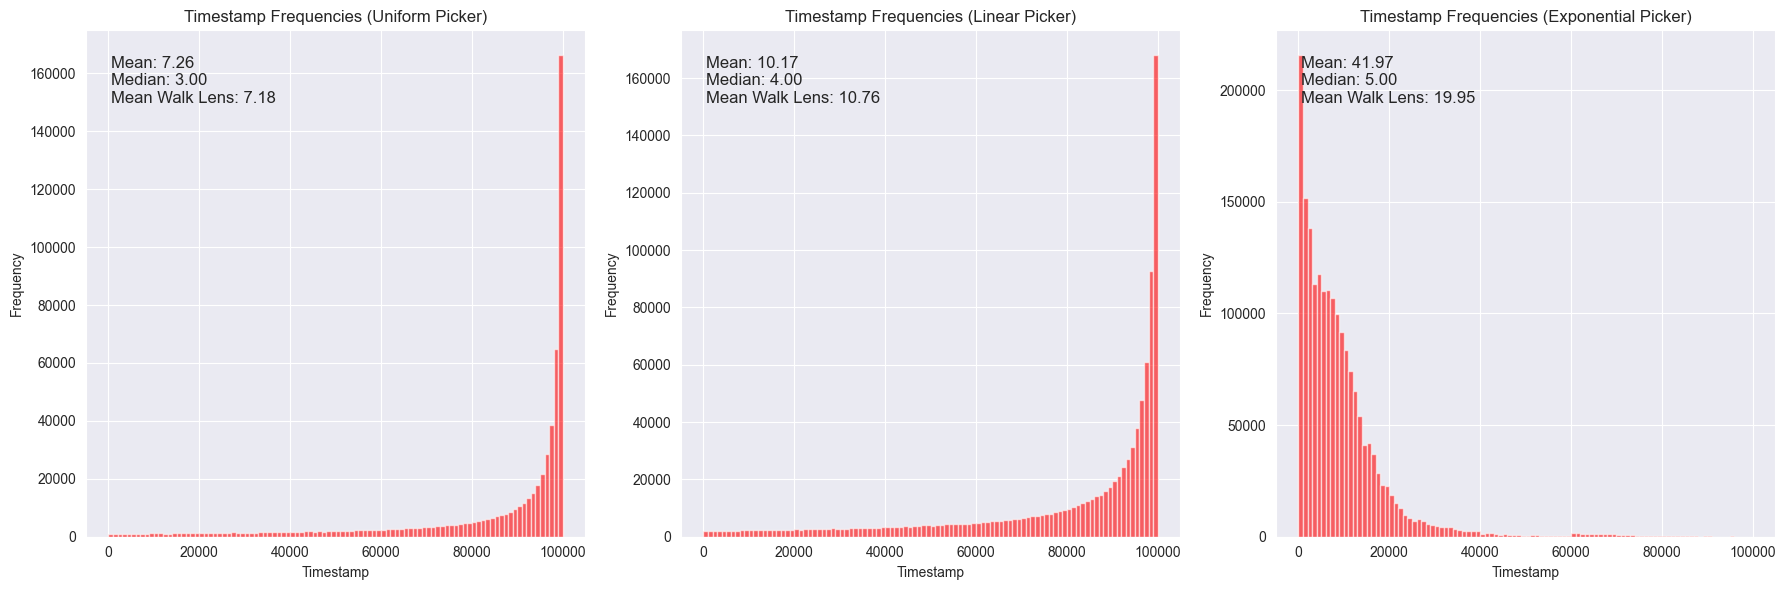

In [10]:
generate_time_vs_interaction_for_pickers(edges)
plt.savefig('plots/picker_comparison_time.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
alibaba_edges = read_data('alibaba')

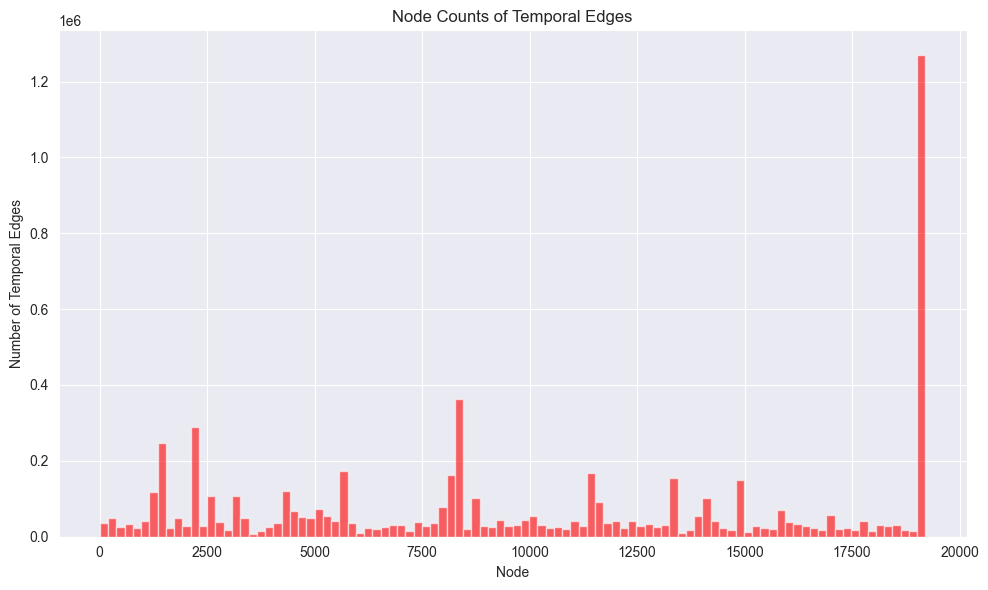

In [12]:
plot_node_counts(alibaba_edges)
plt.savefig('plots/alibaba_true_node_counts.png')
plt.show()

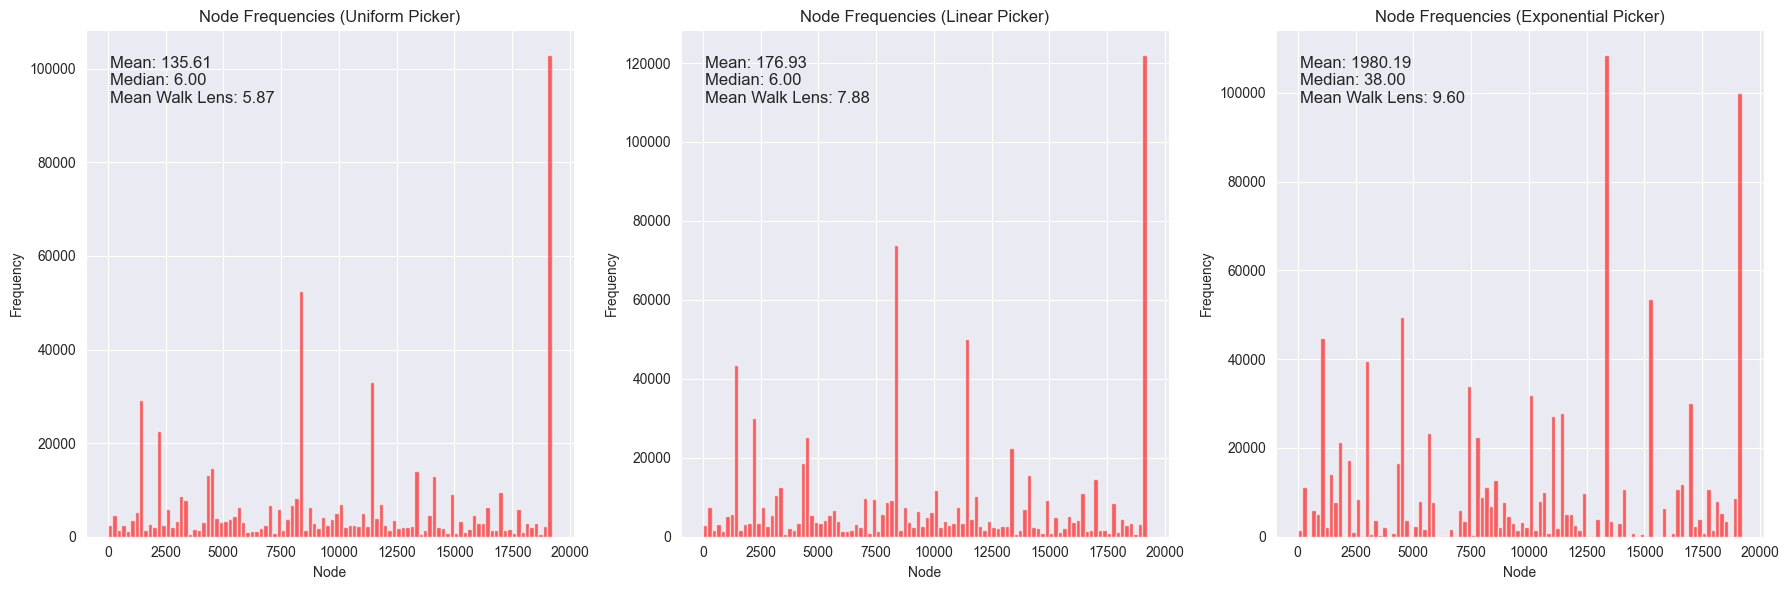

In [13]:
generate_node_vs_interaction_for_pickers(alibaba_edges)
plt.savefig('plots/alibaba_walk_node_counts.png')
plt.show()